# CHSH inequality

-------
## Background

In this tutorial, we'll run an experiment on a quantum computer to demonstrate the violation of the CHSH inequality with the Estimator primitive.

The CHSH inequality, named after the arthors Clauser, Home, Shimony, and Holt, is used to experimentally prove Bell's theorem (1969). This theorem asserts that local hidden variable in quantum mechanics. The violation of the CHSH inequality is used to show that quantum mechanics is incompatible with local hidden-variable theories. This is an important experment for understanding the foundation of quantum mechanics. 

The 2022 Nobel Prize for Physics was awarded to Alain Aspect, John Clauser and Anton Zeilinger in part for their pioneering work in quantum information science, and in particular, for their experiments woth entangled photons demonstrating violation of Bell's inequalties.

***

## Requirements

* Qiskit SDK 1.X or more
* Qiskit Runtime (pip install qiskit-ibm-runtime) 0.22 or later
* Visulization suppport ('qiskit[visualization'])
  
  ****

  ## Setup
  



In [2]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

### Step 1: Map classical inputs to a quantum problem

For this experiment, we will create an entangled pair on which we measure each qubit on two different bases. We will label the bases for the first qubit A and a and the bases for the second qubit B and b. This allows us to compute the CHSH quantity S<sub>1</sub>:

S<sub>1</sub> = A(B - b) + a(B + b).

Each observable is either +1 or -1. Clearly, one of the terms B &plusmn; b must be 0, and the other must be &plusmn;2. Therefore, S<sub>1</sub>=&plusmn2. The average value of S<sub>1</sub> must satisfy the inequality:
$$
|\langle S_1 \rangle| \leq 2
$$

Expanding S<sub>1</sub> in terms of A, a, B, and b results in:

$$
|\langle S_1 \rangle| = |\langle AB \rangle - \langle Ab \rangle + \langle aB \rangle + \langle ab \rangle| \leq 2

$$

You can define another CHSH quantity S<sub>2</sub> :

$$ S_2 = A(B + b) - a(B - b) , $$ 

This leads to another inequality:

$$
|\langle S_2 \rangle| = |\langle AB \rangle + \langle Ab \rangle - \langle aB \rangle + \langle ab \rangle | \leq 2
$$

If quantum mechanics can be described by local hidden variable thiories, the previous inequalities must hold true. However, as is demonstrated in this notebook, these inequalities can be violated in a quantum computer. Therefore, quantum mechanics is not compatible with local hidden variable theories.

We'll create an entangled pair between two qubits in a quantum computer by creating the Bell state 
$$
|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}
$$

Using the Estimator primitive, we can directly obtain the expectation values needed

($\langle AB \rangle$, $\langle Ab \rangle$, $\langle aB \rangle$, and $\langle ab \rangle$) to calculate the expectation values of the two CHSH quantities
($\langle S_1 \rangle$ and $\langle S_2 \rangle$).
Before the introduction of the Estimator primitive, we would have to construct the expection values from the measurement outcomes.

We'll measure the second qubit in Z and X bases. The first qubit will be measured also in orthogonal bases, bur with and angle with respect to the second qubit, which we are going to sweep between 0 and $ 2\pi $. As we'll see, the Estimator primitive makes running parameterized circuits very easy. Rather than creating a series of CHSH circuits, we only need to create one CHSH circuit with a parameter specifying the measurement angle and a series of phase values for the parameter.

Finally, we'll analyze the results and plot them against the measurement angle. We'll see that for certain range of measurement angles, the expaction values of CHSH quantities $ |\langle S_1 \rangle | \gt 2 $ or $ |\langle S_2 \rangle | \gt 2$,
which demonstrate the violation of the CHSH inequality.







In [3]:
# To run of hardware, select the backend woth the fewest number of jobs in the queue
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_cloud")

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="QDcOPHdQw2So98jLrsy7gjR-hnNa6oPDZ4sPHV0bxBW1",
    instance="instance_satya",
    overwrite=True
)


print(service.backends())

backend = service.least_busy(
    operational = True, simulator = False, min_num_qubits=127 
)
backend.name

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


'ibm_torino'

### Create a parameterized CHSH circuit

First, we write the circuit with the parameter $\theta$, which we call *theta*. The Estimator primitive can enormously simplify circuit building and output analysis by directly providing expectation values of observables. Many problems of interest, especially for near-term applications on noisy systems, can be formulated in terms of exoectation values. Estimator (V2) primitive can automatically chabge measurement basis based on the supplied observable.

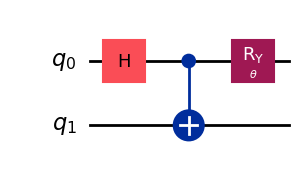

In [5]:
theta = Parameter("$\\theta$")

chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(theta, 0)
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")


### Create a list of phase values to be assigned later

After creating the parameterized CHSH circuit, we'll creat a list of phase values to be assigned to the circuit in the next step. We can use the following code to create a list of 21 phase values range from 0 to 2 $\pi$ with equal spacing, that is, $0, 0.1\pi, 0.2\pi, ....,1.9\pi, 2\pi$. 

In [11]:
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)
# Phases need to be expressed as list of lists in order
individual_phases = [[ph] for ph in phases]

### Observables

Now we need observables from which to compute the expectation values. In our case we are looking at orthogonal bases for each qubit, letting the parameterized Y- rotation for the first qubit sweep the measurement basis nearly continuously with respect to the second qubit basis. We will therefore choose the observables ZZ, ZX, XZ, and XX.


In [8]:
# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list(
    [("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)]
)

# <CHSH2> =<AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list(
    [("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)]
)

## Step 2: Optimize problem for quantum hardware execution

To reduce the total job execution time, V2 primitives only accept circuits and observables that conforms to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).

### ISA Circuit

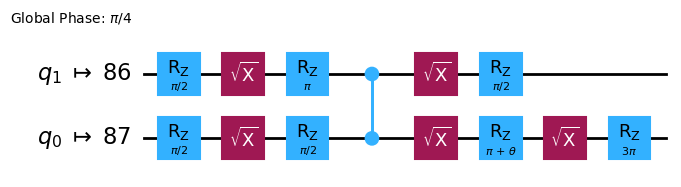

In [6]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

chsh_isa_circuit = pm.run(chsh_circuit)
chsh_isa_circuit.draw(output="mpl", idle_wires=False, style="iqp")

### ISA Observables

Similarly, we need to transform the observables to make it backend compatible before running jobs with *Runtime Estimator V2* . We can perform the transformation using the *apply_layout* the method of SparsePauliOp object.

In [9]:
isa_observable1 = observable1.apply_layout(layout=chsh_isa_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_isa_circuit.layout)


## Step 3: Execute using Qiskit primitives

In order to execute the entire experiment in one call to the Estimator.
We can create a Qiskit Runtime Estimator primitive to compute our expectation values. The EstimatorV2.run() method takes an iterable of primitive unified blocs 
(PUBs) . Each PUB is an iterable in the format (circuit, observables , parameter_values: Optional, precision:Optional) .

In [12]:
# To run on a local simulator:
# Use the StatevectorEstimator from qiskit.primitives instead.

estimator = Estimator(mode=backend)

pub = (
    chsh_isa_circuit, # ISA circuit
    [[isa_observable1], [isa_observable2]], # ISA observables
    individual_phases, # Parameter values
)

job_result = estimator.run(pubs=[pub]).result()


## Step 4:  Post-process and return result in desired classical format

The estimator rerurns expectation values for both of the observables,
$$
\langle ZZ \rangle - \langle ZX \rangle + \langle XZ \rangle + \langle XX \rangle and \langle ZZ \rangle + \langle ZX \rangle - \langle XZ \rangle + \langle XX \rangle


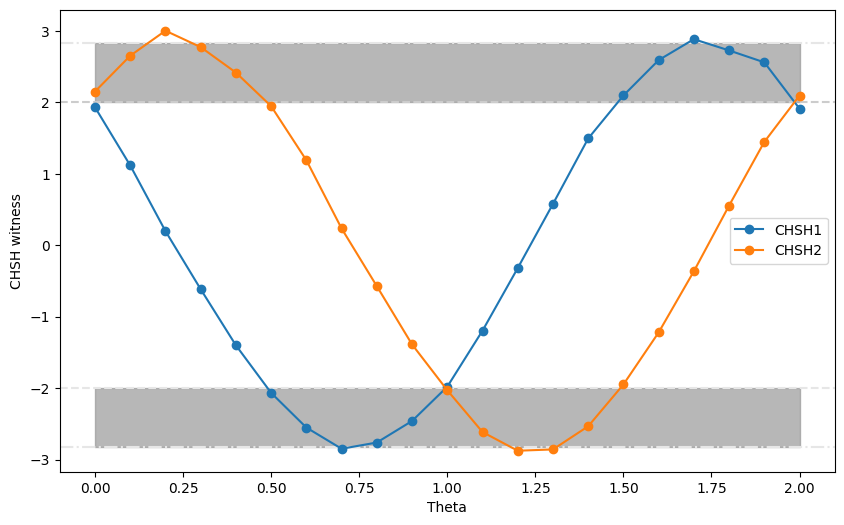

In [22]:
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

fig, ax = plt.subplots(figsize=(10, 6))

# results from hardware
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +- 2
ax.axhline(y=2, color="0.8", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()


In the figure, the lines and gray areas delimit the bounds; the outer-most (dasho=dotted) lines delimit the quantum-bounds $ (\plusmn 2) $, whereas the inner (dashed) lines delimit the classical bounds $(\plusmn 2\sqrt 2)$. We can see that there are regions where the CHSH witness quantities exceeds the classical bounds. 
Congratulations! We have successfully demonstrated the violation of CHSH inequality in a real quantum system!